In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hotel-booking-demand/hotel_bookings.csv


# Load the Dataset

In [2]:
df = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Data Inspection & Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
df.shape

(119390, 32)

In [5]:
# Examine the columns with missing values
df_null = df.isnull().sum()
df_null[df_null.values > 0].sort_values(ascending=False)

company     112593
agent        16340
country        488
children         4
dtype: int64

In [6]:
df[['company', 'agent', 'country', 'children']].head(10)

,company,agent,country,children
0,NaN,NaN,PRT,0.0
1,NaN,NaN,PRT,0.0
2,NaN,NaN,GBR,0.0
3,NaN,304.0,GBR,0.0
4,NaN,240.0,GBR,0.0
5,NaN,240.0,GBR,0.0
6,NaN,NaN,PRT,0.0
7,NaN,303.0,PRT,0.0
8,NaN,240.0,PRT,0.0
9,NaN,15.0,PRT,0.0


In [7]:
# drop missing values
df = df.drop(['company', 'agent'], axis=1)
df = df.dropna(subset=['country', 'children'], axis=0)
df = df.reset_index(drop=True)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [8]:
import datetime

# Converting wrong datatype columns to correct type (object to datetime)
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Converting string month to numerical one (Dec = 12, Jan = 1, etc.)
datetime_object = df['arrival_date_month'].str[0:3]
month_number = np.zeros(len(datetime_object))

# Creating a new column based on numerical representation of the months
for i in range(0, len(datetime_object)):
    datetime_object[i] = datetime.datetime.strptime(datetime_object[i], "%b")
    month_number[i] = datetime_object[i].month

# Float to integer conversion
month_number = pd.DataFrame(month_number).astype(int)

In [9]:
# 3 columns merged into one
df['arrival_date'] = df['arrival_date_year'].map(str) + '-' + month_number[0].map(str) + '-' \
                       + df['arrival_date_day_of_month'].map(str)

In [10]:
# Dropping already used columns
df = df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month',
                  'arrival_date_week_number'], axis=1)
df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,0,0,2,0.0,0,BB,PRT,...,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
1,Resort Hotel,0,737,0,0,2,0.0,0,BB,PRT,...,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
2,Resort Hotel,0,7,0,1,1,0.0,0,BB,GBR,...,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
3,Resort Hotel,0,13,0,1,1,0.0,0,BB,GBR,...,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
4,Resort Hotel,0,14,0,2,2,0.0,0,BB,GBR,...,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-7-1


In [11]:
# convert the newly created arrival_date feature to datetime type
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

In [12]:
# Calculating total guests by combining adults, children and babies columns
df['total guests'] = df['adults'] + df['children'] + df['babies']
df['total guests'].head(10)

0    2.0
1    2.0
2    1.0
3    1.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
Name: total guests, dtype: float64

In [13]:
# drop data points that include zero Total Guests
df = df[df['total guests'] != 0]

In [14]:
# Total Number of Days Stayed
df['total stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

dataNoCancel = df[df['is_canceled'] == 0]
dataNoCancel = dataNoCancel.reset_index(drop=True)

In [15]:
# cross-check for missing values
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_date           0
arrival_date                      0
total guests                

In [16]:
df.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total guests,total stays
count,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000
mean,0.371757,104.401312,0.928307,2.500918,1.861052,0.104356,0.007959,0.031593,0.087208,0.131612,0.218828,2.330638,102.133442,0.061915,0.571778,1.973368,3.429225
std,0.483276,106.915284,0.992725,1.889089,0.574697,0.399439,0.097449,0.174915,0.846419,1.485300,0.638914,17.633065,50.389602,0.244230,0.792740,0.718546,2.528314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,2.000000,2.000000
50%,0.000000,70.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,2.000000,3.000000
75%,1.000000,161.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,2.000000,4.000000
max,1.000000,737.000000,16.000000,40.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,391.000000,5400.000000,8.000000,5.000000,55.000000,56.000000


In [17]:
df.shape

(118728, 29)

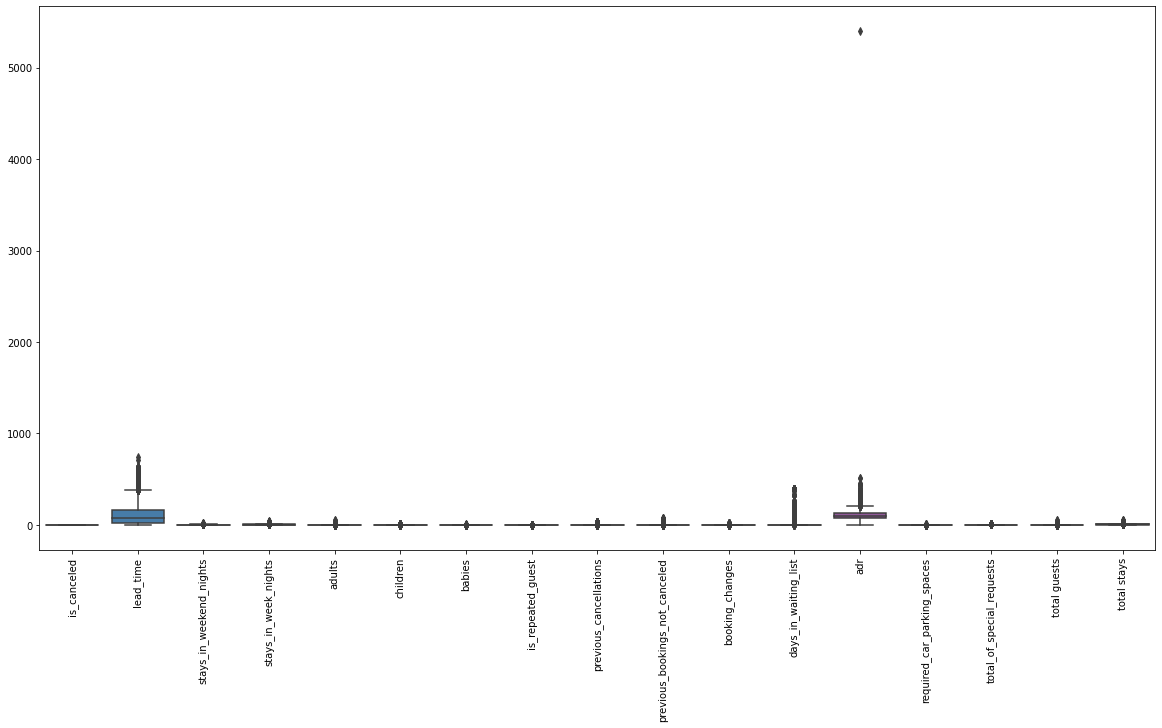

In [18]:
# Data desription to show outliers

plt.figure(figsize=(20,10))
sns.boxplot(data=df, palette="Set1")
plt.xticks(rotation=90)
plt.show()

In [19]:
df.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [20]:
df.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [21]:
df.deposit_type.unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

## Data Visualization

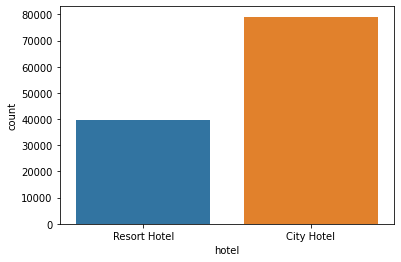

In [22]:
sns.countplot(x="hotel",data = df)
plt.show()

The output is imbalaced. City hotel carries the majority of the count of visits

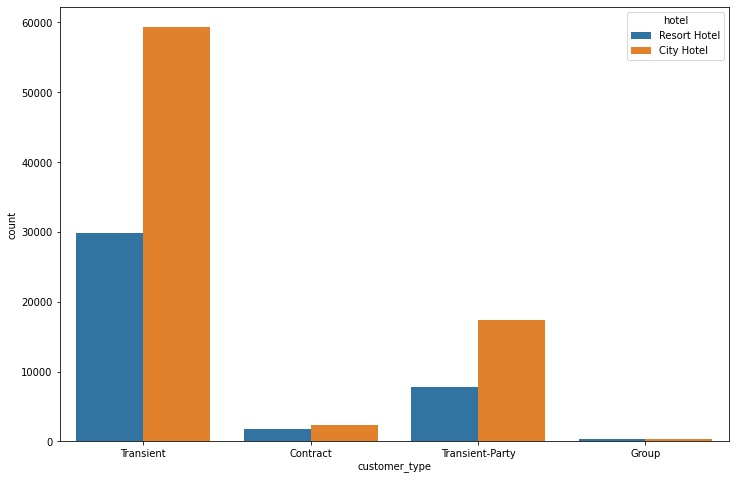

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(x="customer_type",hue='hotel', data = df)
plt.show()

Most of the customers that visit the hotels are transient

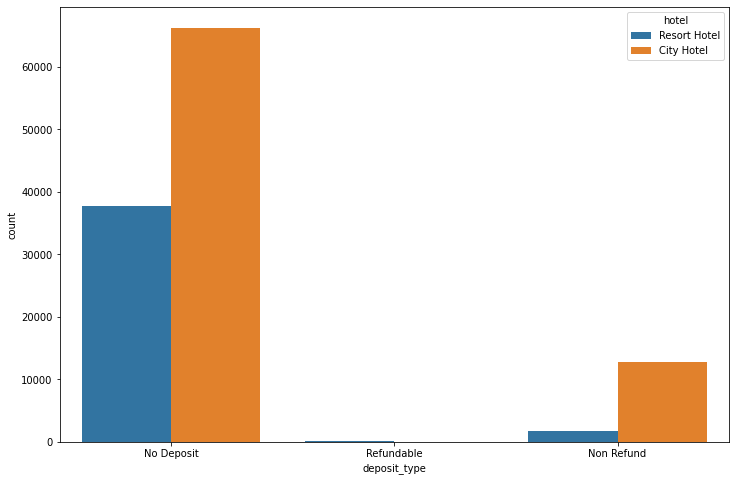

In [24]:
plt.figure(figsize=(12,8))
sns.countplot(x="deposit_type",hue='hotel', data = df)
plt.show()

The two hotels mostly accept the 'no deposit' payment option

Text(0.5, 1.0, 'Correlation')

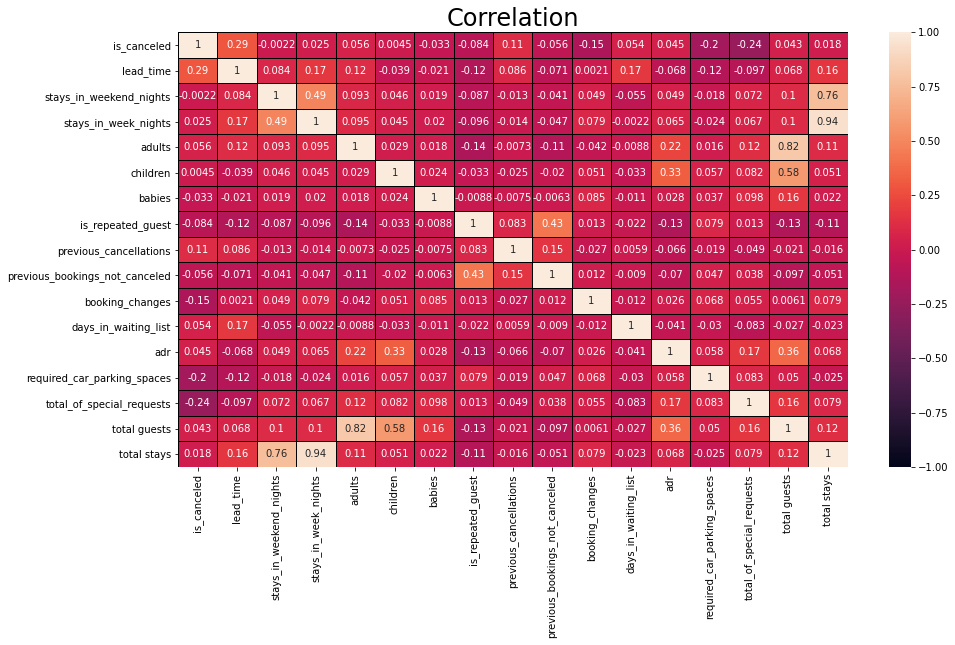

In [25]:
plt.figure(figsize=(15, 8))
correlation = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, linewidths=1, linecolor='black')
correlation.set_title('Correlation', fontdict={'fontsize': 24})

In [26]:
df = df.drop(['adults', 'children', 'babies', 'stays_in_weekend_nights', 'stays_in_week_nights', 'arrival_date', 'reservation_status_date'], axis=1)

Text(0.5, 1.0, 'Correlation')

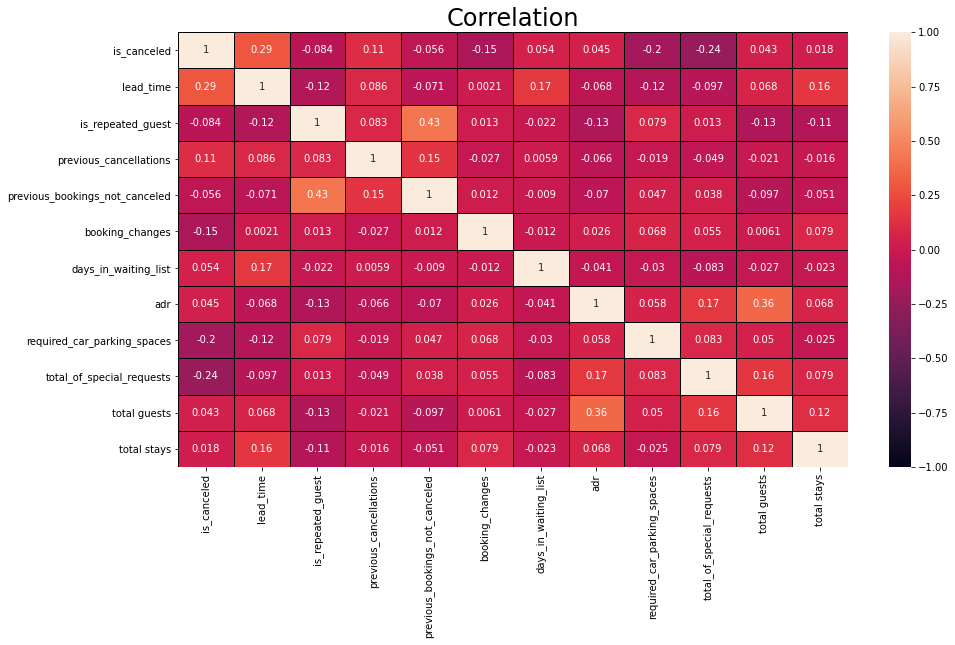

In [27]:
plt.figure(figsize=(15, 8))
correlation = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, linewidths=1, linecolor='black')
correlation.set_title('Correlation', fontdict={'fontsize': 24})

In [28]:
df.shape

(118728, 22)

In [29]:
# Categorical variables preprocessing with label encoding
list_1 = list(df.columns)
cate_list=[]
for i in list_1:
    if df[i].dtype=='object':
        cate_list.append(i)

In [30]:
cate_list

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status']

In [31]:
# transform the categorical variables with label encoder
le = LabelEncoder()
for i in cate_list:
    df[i] = le.fit_transform(df[i])
df.head(10)

,hotel,is_canceled,lead_time,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total guests,total stays
0,1,0,342,0,135,3,1,0,0,0,...,3,0,0,2,0.0,0,0,1,2.0,0
1,1,0,737,0,135,3,1,0,0,0,...,4,0,0,2,0.0,0,0,1,2.0,0
2,1,0,7,0,59,3,1,0,0,0,...,0,0,0,2,75.0,0,0,1,1.0,1
3,1,0,13,0,59,2,0,0,0,0,...,0,0,0,2,75.0,0,0,1,1.0,1
4,1,0,14,0,59,6,3,0,0,0,...,0,0,0,2,98.0,0,1,1,2.0,2
5,1,0,14,0,59,6,3,0,0,0,...,0,0,0,2,98.0,0,1,1,2.0,2
6,1,0,0,0,135,3,1,0,0,0,...,0,0,0,2,107.0,0,0,1,2.0,2
7,1,0,9,1,135,3,1,0,0,0,...,0,0,0,2,103.0,0,1,1,2.0,2
8,1,1,85,0,135,6,3,0,0,0,...,0,0,0,2,82.0,0,1,0,2.0,3
9,1,1,75,2,135,5,3,0,0,0,...,0,0,0,2,105.5,0,0,0,2.0,3


In [32]:
df.head()

,hotel,is_canceled,lead_time,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total guests,total stays
0,1,0,342,0,135,3,1,0,0,0,...,3,0,0,2,0.0,0,0,1,2.0,0
1,1,0,737,0,135,3,1,0,0,0,...,4,0,0,2,0.0,0,0,1,2.0,0
2,1,0,7,0,59,3,1,0,0,0,...,0,0,0,2,75.0,0,0,1,1.0,1
3,1,0,13,0,59,2,0,0,0,0,...,0,0,0,2,75.0,0,0,1,1.0,1
4,1,0,14,0,59,6,3,0,0,0,...,0,0,0,2,98.0,0,1,1,2.0,2


In [33]:
df.hotel.value_counts()

0    79143
1    39585
Name: hotel, dtype: int64

In [34]:
# split the data into dependent variables and independent variable
X = df.drop(['hotel'],axis=1)
y = df.hotel

In [35]:
# split the data into training and test set

X_train,X_test,y_train,y_test = tts(X,y,random_state=36,test_size=0.3)

In [36]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Model Training

We want to train a model to predict the possibility of booking either of the two hotels

### Logistic Regression

In [37]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)  

LogisticRegression()

In [38]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
y_pred = log_reg.predict(X_test)
acc_reg = round(accuracy_score(y_test, y_pred), 3)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",log_reg.score(X_train,y_train)*100)
print(f"Accuracy Score of Logistic Regression is : {acc_reg}")

Classification Report is:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85     23765
           1       0.75      0.52      0.61     11854

    accuracy                           0.78     35619
   macro avg       0.77      0.71      0.73     35619
weighted avg       0.78      0.78      0.77     35619

Confusion Matrix:
 [[21678  2087]
 [ 5747  6107]]
Training Score:
 77.59207787363582
Accuracy Score of Logistic Regression is : 0.78


### K-Nearest Neighbours

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = round(accuracy_score(y_test, y_pred_knn), 3)
conf = confusion_matrix(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of KNN is : 0.9
Confusion Matrix : 
[[22324  1441]
 [ 2129  9725]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     23765
           1       0.87      0.82      0.84     11854

    accuracy                           0.90     35619
   macro avg       0.89      0.88      0.89     35619
weighted avg       0.90      0.90      0.90     35619



### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
clf = classification_report(y_test, y_pred)

acc_rf = round(accuracy_score(y_test, y_pred), 3)
score = round(accuracy_score(y_test,y_pred), 2)
print(f"Accuracy Score of RandomForest is : {score}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf}")       

Accuracy Score of RandomForest is : 0.93
Confusion Matrix : 
[[22291  1474]
 [ 1142 10712]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     23765
           1       0.88      0.90      0.89     11854

    accuracy                           0.93     35619
   macro avg       0.92      0.92      0.92     35619
weighted avg       0.93      0.93      0.93     35619



In [41]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(221)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
keras_model = Sequential()
keras_model.add(Dense(100, activation='relu', input_dim=21))
keras_model.add(BatchNormalization())
#keras_model.add(Dense(80, activation='relu'))
#keras_model.add(Dropout(0.2))
keras_model.add(Dense(40, activation='relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(1, activation='sigmoid'))

keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
keras_model.fit(X_train, y_train, epochs=40)

Epoch 1/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.4092 - accuracy: 0.8181
Epoch 2/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2992 - accuracy: 0.8775
Epoch 3/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2701 - accuracy: 0.8891
Epoch 4/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2519 - accuracy: 0.8966
Epoch 5/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2403 - accuracy: 0.9007
Epoch 6/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2369 - accuracy: 0.9042
Epoch 7/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2307 - accuracy: 0.9057
Epoch 8/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2282 - accuracy: 0.9061
Epoch 9/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.2194 - accuracy: 0.9109
Epoch 10/40
2598/2598 [==============================] - 5s 2ms/step - loss: 0.221

In [43]:
eval_keras = keras_model.evaluate(X_test,y_test, verbose=0) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval_keras[0], \
  eval_keras[1]*100))


Loss, accuracy on test data: 
0.1980 92.09%


<Figure size 1080x720 with 0 Axes>

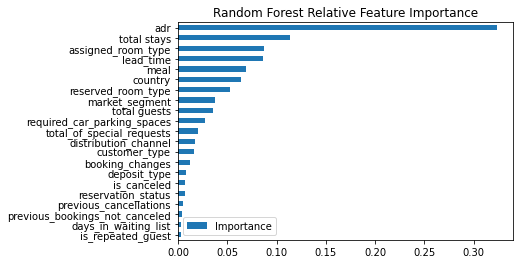

In [54]:
# Plot feature importance
plt.figure(figsize=(15,10))
featureImport = pd.DataFrame(rfc.feature_importances_, index=X.columns)
featureImport.columns = ["Importance"]
featureImport.sort_values(["Importance"], ascending=True).plot(kind="barh")
plt.title("Random Forest Relative Feature Importance")
plt.show()

Text(0.5, 1.0, 'Model Results')

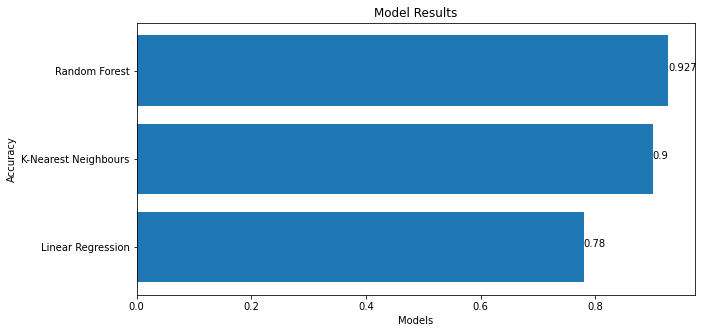

In [47]:
results = [acc_reg, acc_knn, acc_rf]
names = ['Linear Regression', 'K-Nearest Neighbours', 'Random Forest']
plt.figure(figsize=(10, 5))
plt.barh(names,results)

for index, value in enumerate(results):
    plt.text(value, index, str(value))
plt.xlabel('Models')
plt.ylabel("Accuracy")
plt.title('Model Results')